## Modeling - Best parameters

In this notebook, we are going to fit each model with the best hyperparameter found in the 'Parameter_selection_notebooks' and evaluate the performance of each model with the validation split

In [1]:
import numpy as np
import pandas as pd
from pipeline import *

import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

from sklearn.metrics import confusion_matrix,  precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
from sklearn.metrics import make_scorer

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
sns.set()
pd.set_option('display.precision', 3)

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42) # for reproducibility
rng = 42

# Funcitons

In [2]:
def plot_confusion_matrix(y_true, y_pred, vmax = 7000):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index = ['Not Voted','Voted'],columns = ['Not Voted','Voted'])
    plt.figure(figsize=(5.5,4))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='g', vmin=0, vmax=vmax)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

def compute_metrics(y_true,y_pred):
    f1_score_0 = f1_score(y_true,y_pred,average='binary',pos_label=0)
    f1_score_1 = f1_score(y_true,y_pred,average='binary',pos_label=1)
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    recall_0 = recall_score(y_true,y_pred,average='binary',pos_label=0)
    precision_0 = precision_score(y_true,y_pred,average='binary',pos_label=0)
    AP_macro = average_precision_score(y_true,y_pred,average='macro')
    roc_auc_macro = roc_auc_score(y_true,y_pred,average='macro')
    return [f1_score_0,f1_score_1,f1_score_macro,recall_0,precision_0,AP_macro,roc_auc_macro]

f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)
recall_class_0_scorer = make_scorer(recall_score, pos_label=0)
precision_class_0_scorer = make_scorer(precision_score, pos_label=0)
average_precision_score_macro = make_scorer(average_precision_score, average='macro')
roc_auc_macro_scorer = make_scorer(roc_auc_score, average='macro')

scoring_dict = {
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'f1_macro': 'f1_macro',
    'recall_0': recall_class_0_scorer,
    'precision_0': precision_class_0_scorer,
    'AP_macro': average_precision_score_macro,
    'roc_auc_macro': roc_auc_macro_scorer,
}

Get the data

In [3]:
X_train, X_test, y_train, y_test = get_train_test(balanced=False)
# split the train into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rng)
X_train.shape, X_val.shape, X_test.shape
results_voted = pd.DataFrame(index=[], columns= ['F1 C0', 'F1 C1', 'F1 Macro', 'Recall C0', 'Precision C0', 'AP Macro', 'ROC AUC Macro'])

set()


((44310, 33), (11078, 33), (13848, 33))

## LDA

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['NFAMS', 'FAMSIZE', 'NCHILD',
                                                   'NCHLT5', 'NSIBS',
                                                   'YRIMMIG']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=25,
                                                                sparse_output=False),
                                                  ['GQTYPE', 'METRO', 'INTTYPE',
                                                   'SEX', 'VETSTAT', 'CITIZEN',
                                                   'DIFFANY', 'COVIDUNAW',
                                                   'NATIVITY', 'COVIDPAID',
                                                   'STATEFIP', 'RELATE', 'RACE',
                                                   'MARST', 'BPL', 'MBPL',
                                                   'FBPL', 'HISPAN', 'EMPSTAT',
                                                   'CLASSWKR',
                                                   'EMPSTAT_HEAD']),
                                                 ('imputer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['UHRSWORKT'])])),
                ('undersampler', SMOTE(random_state=42)),
                ('classifier', LinearDiscriminantAnalysis())])

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
LDA,0.509,0.792,0.65,0.723,0.392,0.872,0.713


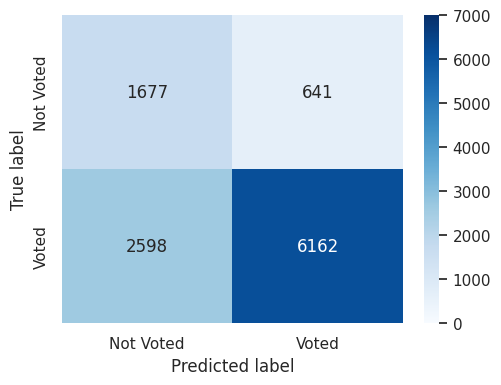

0:00:50.314361


In [4]:
init_time = time()

# Define and configure the LDA pipeline
lda = imbPipeline([
        ('preprocessing', preprocessing_oh),
        ('undersampler', SMOTE(random_state=rng)),
        ('classifier', LinearDiscriminantAnalysis())
    ])

# Fit and predict the model
lda.fit(X_train, y_train)
y_pred = lda.predict(X_val)

# Compute metrics
results = pd.DataFrame(index=[], columns= ['F1 C0', 'F1 C1', 'F1 Macro', 'Recall C0', 'Precision C0', 'AP Macro', 'ROC AUC Macro'])
results.loc['LDA'] = compute_metrics(y_val, y_pred)
results

# Plot confusion matrix
plt = plot_confusion_matrix(y_val, y_pred)
plt.show()

print(timedelta(seconds=(time() - init_time)))

## QDA

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['NFAMS', 'FAMSIZE', 'NCHILD',
                                                   'NCHLT5', 'NSIBS',
                                                   'YRIMMIG']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=25,
                                                                sparse_output=False),
                                                  ['GQTYPE', 'METRO', 'INTTYPE',
                                                   'SEX', 'VETSTAT', 'CITIZEN',
                                                   'DIFFANY', 'COVIDUNAW',
                                                   'NAT...Y', 'COVIDPAID',
                                                   'STATEFIP', 'RELATE', 'RACE',
                                                   'MARST', 'BPL', 'MBPL',
                                                   'FBPL', 'HISPAN', 'EMPSTAT',
                                                   'CLASSWKR',
                                                   'EMPSTAT_HEAD']),
                                                 ('imputer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['UHRSWORKT'])])),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('classifier', QuadraticDiscriminantAnalysis(reg_param=0.5))])

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
LDA,0.509,0.792,0.650,0.723,0.392,0.872,0.713
QDA,0.494,0.805,0.649,0.657,0.396,0.864,0.696


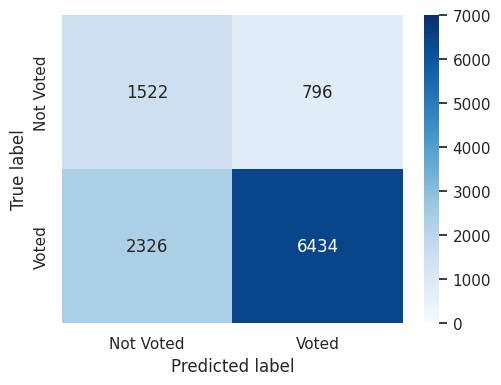

0:00:14.785727


In [5]:
init_time = time()

# Best parameters found
params = {'reg_param': 0.5}

# Define and configure the QDA pipeline
qda = imbPipeline([
        ('preprocessing', preprocessing_oh),
        ('undersampler', RandomUnderSampler(random_state=rng)),
        ('classifier', QuadraticDiscriminantAnalysis(**params))        
    ])

# Fit and predict the model
qda.fit(X_train, y_train)
y_pred = qda.predict(X_val)

# Compute metrics
results.loc['QDA'] = compute_metrics(y_val, y_pred)
results

# Plot confusion matrix
plt = plot_confusion_matrix(y_val, y_pred)
plt.show()

print(timedelta(seconds=(time() - init_time)))

### NB

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['NFAMS', 'FAMSIZE', 'NCHILD',
                                                   'NCHLT5', 'NSIBS',
                                                   'YRIMMIG']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=25,
                                                                sparse_output=False),
                                                  ['GQTYPE', 'METRO', 'INTTYPE',
                                                   'SEX', 'VETSTAT', 'CITIZEN',
                                                   'DIFFANY', 'COVIDUNAW',
                                                   'NATIVITY', 'COVIDPAID',
                                                   'STATEFIP', 'RELATE', 'RACE',
                                                   'MARST', 'BPL', 'MBPL',
                                                   'FBPL', 'HISPAN', 'EMPSTAT',
                                                   'CLASSWKR',
                                                   'EMPSTAT_HEAD']),
                                                 ('imputer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['UHRSWORKT'])])),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('classifier', GaussianNB())])

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
LDA,0.509,0.792,0.650,0.723,0.392,0.872,0.713
QDA,0.494,0.805,0.649,0.657,0.396,0.864,0.696
GNB,0.490,0.807,0.648,0.645,0.396,0.862,0.692


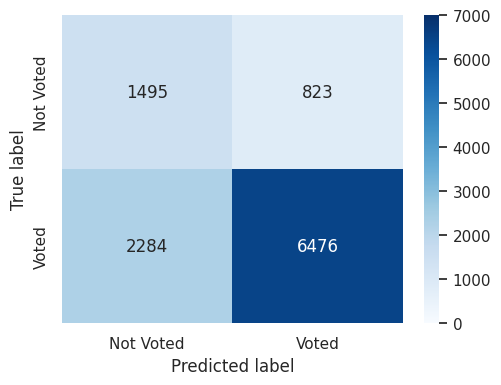

0:00:02.334382


In [6]:
init_time = time()

# Define and configure the GNB pipeline
gnb = imbPipeline([
        ('preprocessing', preprocessing_oh),
        ('undersampler', RandomUnderSampler(random_state=rng)),
        ('classifier', GaussianNB())
    ])

# Fit and predict the model
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_val)

# Compute metrics
results.loc['GNB'] = compute_metrics(y_val, y_pred)
results

# Plot confusion matrix
plt = plot_confusion_matrix(y_val, y_pred)
plt.show()

print(timedelta(seconds=(time() - init_time)))

### KNN

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['NFAMS', 'FAMSIZE', 'NCHILD',
                                                   'NCHLT5', 'NSIBS',
                                                   'YRIMMIG']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=25,
                                                                sparse_output=False),
                                                  ['GQTYPE', 'METRO', 'INTTYPE',
                                                   'SEX', 'VETSTAT', 'CITIZEN',
                                                   'DIFFANY', 'COVIDUNAW',
                                                   'NATIVITY', 'COVIDPAID',
                                                   'STATEFIP', 'RELATE', 'RACE',
                                                   'MARST', 'BPL', 'MBPL',
                                                   'FBPL', 'HISPAN', 'EMPSTAT',
                                                   'CLASSWKR',
                                                   'EMPSTAT_HEAD']),
                                                 ('imputer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['UHRSWORKT'])])),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('classifier', KNeighborsClassifier(n_neighbors=43))])

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
LDA,0.509,0.792,0.650,0.723,0.392,0.872,0.713
QDA,0.494,0.805,0.649,0.657,0.396,0.864,0.696
GNB,0.490,0.807,0.648,0.645,0.396,0.862,0.692
KNN,0.490,0.791,0.640,0.681,0.382,0.864,0.695


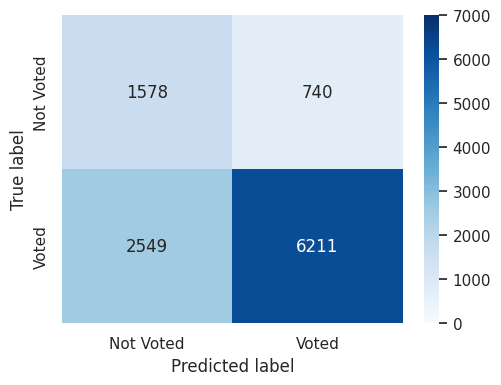

0:00:05.872943


In [7]:
init_time = time()

# Best parameters found
params = {'n_neighbors': 43}

# Define and configure the KNN pipeline
knn = imbPipeline([
        ('preprocessing', preprocessing_oh),
        ('undersampler', RandomUnderSampler(random_state=rng)),
        ('classifier', KNeighborsClassifier(**params))
    ])

# Fit and predict the model
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)

# Compute metrics
results.loc['KNN'] = compute_metrics(y_val, y_pred)
results

# Plot confusion matrix
plt = plot_confusion_matrix(y_val, y_pred)
plt.show()

print(timedelta(seconds=(time() - init_time)))

### Logistic Regression

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['NFAMS', 'FAMSIZE', 'NCHILD',
                                                   'NCHLT5', 'NSIBS',
                                                   'YRIMMIG']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=25,
                                                                sparse_output=False),
                                                  ['GQTYPE', 'METRO', 'INTTYPE',
                                                   'SEX', 'VETSTAT', 'CITIZEN',
                                                   'DIFFANY', 'COVIDUNAW',
                                                   'NAT...',
                                                   'STATEFIP', 'RELATE', 'RACE',
                                                   'MARST', 'BPL', 'MBPL',
                                                   'FBPL', 'HISPAN', 'EMPSTAT',
                                                   'CLASSWKR',
                                                   'EMPSTAT_HEAD']),
                                                 ('imputer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['UHRSWORKT'])])),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=10000, random_state=42))])

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
LDA,0.509,0.792,0.650,0.723,0.392,0.872,0.713
QDA,0.494,0.805,0.649,0.657,0.396,0.864,0.696
GNB,0.490,0.807,0.648,0.645,0.396,0.862,0.692
KNN,0.490,0.791,0.640,0.681,0.382,0.864,0.695
LR,0.359,0.767,0.563,0.458,0.295,0.820,0.584


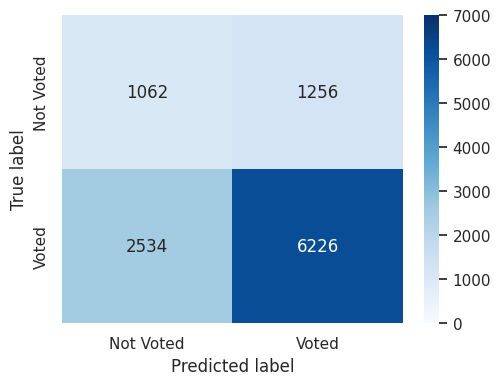

0:00:05.047820


In [8]:
init_time = time()

# Best parameters found
params = {'penalty': 'l2',
          'C': 0.01,
          'max_iter': 10000}

# Define and configure the LR pipeline
lr = imbPipeline([
        ('preprocessing', preprocessing_oh),
        ('undersampler', RandomUnderSampler(random_state=rng)),
        ('classifier', LogisticRegression(**params, random_state=rng))
    ])

# Fit and predict the model
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

# Compute metrics
results.loc['LR'] = compute_metrics(y_val, y_pred)
results

# Plot confusion matrix
plt = plot_confusion_matrix(y_val, y_pred)
plt.show()

print(timedelta(seconds=(time() - init_time)))

### Decision Tree

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['NFAMS', 'FAMSIZE', 'NCHILD',
                                                   'NCHLT5', 'NSIBS',
                                                   'YRIMMIG']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['GQTYPE', 'METRO', 'INTTYPE',
                                                   'SEX', 'VETSTAT', 'CITIZEN',
                                                   'DIFFANY', 'COVIDUNAW',
                                                   'NATIVITY', 'COVIDPAID']),
                                                 ('target_econder',
                                                  TargetEncod...
                                                  ['STATEFIP', 'RELATE', 'RACE',
                                                   'MARST', 'BPL', 'MBPL',
                                                   'FBPL', 'HISPAN', 'EMPSTAT',
                                                   'CLASSWKR',
                                                   'EMPSTAT_HEAD']),
                                                 ('imputer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['UHRSWORKT'])])),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_split=5,
                                        random_state=42))])

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
LDA,0.509,0.792,0.650,0.723,0.392,0.872,0.713
QDA,0.494,0.805,0.649,0.657,0.396,0.864,0.696
GNB,0.490,0.807,0.648,0.645,0.396,0.862,0.692
KNN,0.490,0.791,0.640,0.681,0.382,0.864,0.695
LR,0.359,0.767,0.563,0.458,0.295,0.820,0.584
DT,0.488,0.765,0.627,0.733,0.366,0.866,0.698


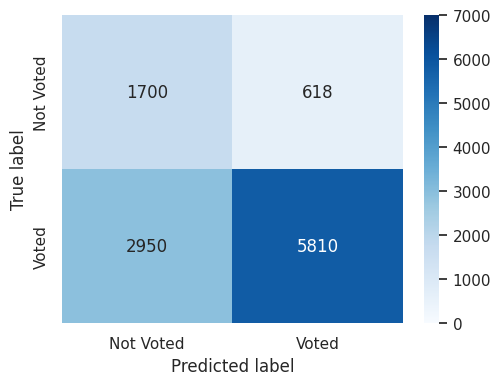

0:00:03.953865


In [9]:
init_time = time()

# Best parameters found
params = {'criterion': 'gini',
          'max_depth': 5,
          'max_features': None,
          'min_samples_leaf': 1,
          'min_samples_split': 5}

# Define and configure the DT pipeline
dt = imbPipeline([
        ('preprocessing', preprocessing_oh_target),
        ('undersampler', RandomUnderSampler(random_state=rng)),
        ('classifier', DecisionTreeClassifier(**params, random_state=rng))
    ])

# Fit and predict the model
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)

# Compute metrics
results.loc['DT'] = compute_metrics(y_val, y_pred)
results

# Plot confusion matrix
plt = plot_confusion_matrix(y_val, y_pred)
plt.show()

print(timedelta(seconds=(time() - init_time)))

### Random Forest

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['NFAMS', 'FAMSIZE', 'NCHILD',
                                                   'NCHLT5', 'NSIBS',
                                                   'YRIMMIG']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['GQTYPE', 'METRO', 'INTTYPE',
                                                   'SEX', 'VETSTAT', 'CITIZEN',
                                                   'DIFFANY', 'COVIDUNAW',
                                                   'NATIVITY', 'COVIDPAID']),
                                                 ('target_econder',
                                                  TargetEncod...
                                                  ['STATEFIP', 'RELATE', 'RACE',
                                                   'MARST', 'BPL', 'MBPL',
                                                   'FBPL', 'HISPAN', 'EMPSTAT',
                                                   'CLASSWKR',
                                                   'EMPSTAT_HEAD']),
                                                 ('imputer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['UHRSWORKT'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_leaf=6, min_samples_split=4,
                                        n_estimators=200, random_state=42))])

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
LDA,0.509,0.792,0.650,0.723,0.392,0.872,0.713
QDA,0.494,0.805,0.649,0.657,0.396,0.864,0.696
GNB,0.490,0.807,0.648,0.645,0.396,0.862,0.692
KNN,0.490,0.791,0.640,0.681,0.382,0.864,0.695
LR,0.359,0.767,0.563,0.458,0.295,0.820,0.584
DT,0.488,0.765,0.627,0.733,0.366,0.866,0.698
RF,0.525,0.845,0.685,0.617,0.456,0.869,0.711


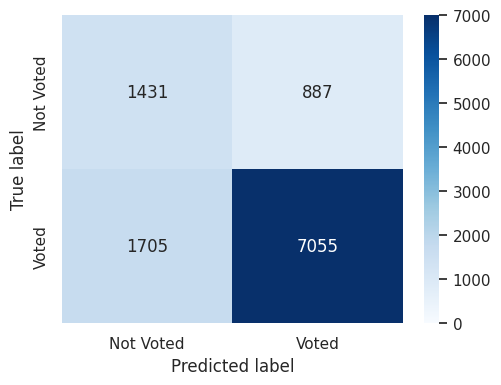

0:00:17.021048


In [10]:
init_time = time()

# Best parameters found
params = {'class_weight': 'balanced_subsample',
          'max_depth': None,
          'min_samples_leaf': 6,
          'min_samples_split': 4,
          'n_estimators': 200}

# Define and configure the RF pipeline
rf = imbPipeline([
        ('preprocessing', preprocessing_oh_target),
        ('classifier', RandomForestClassifier(**params, random_state=rng))
    ])

# Fit and predict the model
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

# Compute metrics
results.loc['RF'] = compute_metrics(y_val, y_pred)
results

# Plot confusion matrix
plt = plot_confusion_matrix(y_val, y_pred)
plt.show()

print(timedelta(seconds=(time() - init_time)))

### Extra Trees

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['NFAMS', 'FAMSIZE', 'NCHILD',
                                                   'NCHLT5', 'NSIBS',
                                                   'YRIMMIG']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['GQTYPE', 'METRO', 'INTTYPE',
                                                   'SEX', 'VETSTAT', 'CITIZEN',
                                                   'DIFFANY', 'COVIDUNAW',
                                                   'NATIVITY', 'COVIDPAID']),
                                                 ('target_econder',
                                                  TargetEncod...
                                                  ['STATEFIP', 'RELATE', 'RACE',
                                                   'MARST', 'BPL', 'MBPL',
                                                   'FBPL', 'HISPAN', 'EMPSTAT',
                                                   'CLASSWKR',
                                                   'EMPSTAT_HEAD']),
                                                 ('imputer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['UHRSWORKT'])])),
                ('classifier',
                 ExtraTreesClassifier(class_weight='balanced_subsample',
                                      min_samples_leaf=4, min_samples_split=4,
                                      n_estimators=150, random_state=42))])

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
LDA,0.509,0.792,0.650,0.723,0.392,0.872,0.713
QDA,0.494,0.805,0.649,0.657,0.396,0.864,0.696
GNB,0.490,0.807,0.648,0.645,0.396,0.862,0.692
KNN,0.490,0.791,0.640,0.681,0.382,0.864,0.695
LR,0.359,0.767,0.563,0.458,0.295,0.820,0.584
DT,0.488,0.765,0.627,0.733,0.366,0.866,0.698
RF,0.525,0.845,0.685,0.617,0.456,0.869,0.711
ET,0.516,0.828,0.672,0.645,0.429,0.869,0.709


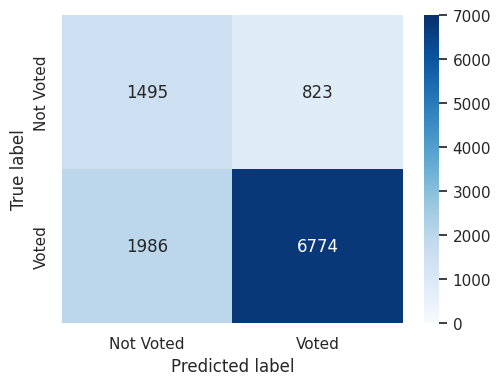

0:00:12.789270


In [11]:
init_time = time()

# Best parameters found
params = {'class_weight': 'balanced_subsample',
          'max_depth': None,
          'min_samples_leaf': 4,
          'min_samples_split': 4,
          'n_estimators': 150}

# Define and configure the ET pipeline
et = imbPipeline([
        ('preprocessing', preprocessing_oh_target),
        ('classifier', ExtraTreesClassifier(**params, random_state=rng))
    ])

# Fit and predict the model
et.fit(X_train, y_train)
y_pred = et.predict(X_val)

# Compute metrics
results.loc['ET'] = compute_metrics(y_val, y_pred)
results

# Plot confusion matrix
plt = plot_confusion_matrix(y_val, y_pred)
plt.show()

print(timedelta(seconds=(time() - init_time)))

### AdaBoost

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['NFAMS', 'FAMSIZE', 'NCHILD',
                                                   'NCHLT5', 'NSIBS',
                                                   'YRIMMIG']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['GQTYPE', 'METRO', 'INTTYPE',
                                                   'SEX', 'VETSTAT', 'CITIZEN',
                                                   'DIFFANY', 'COVIDUNAW',
                                                   'NATIVITY', 'COVIDPAID']),
                                                 ('target_econder',
                                                  TargetEncod...
                                                   'EMPSTAT_HEAD']),
                                                 ('imputer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['UHRSWORKT'])])),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('classifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                                     min_samples_leaf=10,
                                                                     random_state=42),
                                    learning_rate=0.15, n_estimators=300,
                                    random_state=42))])

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
LDA,0.509,0.792,0.650,0.723,0.392,0.872,0.713
QDA,0.494,0.805,0.649,0.657,0.396,0.864,0.696
GNB,0.490,0.807,0.648,0.645,0.396,0.862,0.692
KNN,0.490,0.791,0.640,0.681,0.382,0.864,0.695
LR,0.359,0.767,0.563,0.458,0.295,0.820,0.584
DT,0.488,0.765,0.627,0.733,0.366,0.866,0.698
RF,0.525,0.845,0.685,0.617,0.456,0.869,0.711
ET,0.516,0.828,0.672,0.645,0.429,0.869,0.709
AB,0.517,0.799,0.658,0.726,0.401,0.874,0.720


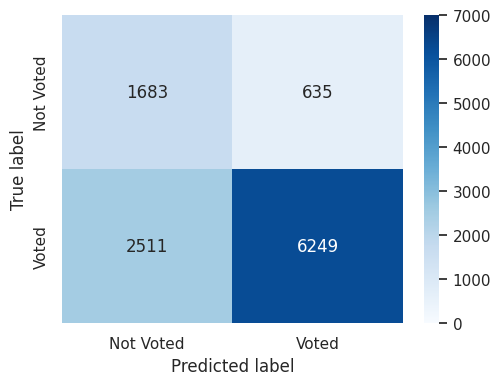

0:00:13.871989


In [12]:
init_time = time()

# Best parameters found
estimator_params = {'max_depth': 2,
                    'min_samples_leaf': 10}

params = {'learning_rate': 0.15,
          'n_estimators': 300}


# Define and configure the ABC pipeline
abc = imbPipeline([
        ('preprocessing', preprocessing_oh_target),
        ('undersampler', RandomUnderSampler(random_state=rng)),
        ('classifier', AdaBoostClassifier(estimator=DecisionTreeClassifier(**estimator_params, random_state=rng),**params, random_state=rng))
    ])

# Fit and predict the model
abc.fit(X_train, y_train)
y_pred = abc.predict(X_val)

# Compute metrics
results.loc['AB'] = compute_metrics(y_val, y_pred)
results

# Plot confusion matrix
plt = plot_confusion_matrix(y_val, y_pred)
plt.show()

print(timedelta(seconds=(time() - init_time)))

### Gradient Boosting

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['NFAMS', 'FAMSIZE', 'NCHILD',
                                                   'NCHLT5', 'NSIBS',
                                                   'YRIMMIG']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['GQTYPE', 'METRO', 'INTTYPE',
                                                   'SEX', 'VETSTAT', 'CITIZEN',
                                                   'DIFFANY', 'COVIDUNAW',
                                                   'NATIVITY', 'COVIDPAID']),
                                                 ('target_econder',
                                                  TargetEncod...
                                                   'FBPL', 'HISPAN', 'EMPSTAT',
                                                   'CLASSWKR',
                                                   'EMPSTAT_HEAD']),
                                                 ('imputer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['UHRSWORKT'])])),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('classifier',
                 GradientBoostingClassifier(max_depth=10, max_features='sqrt',
                                            min_samples_leaf=0.01,
                                            min_samples_split=0.2,
                                            random_state=42))])

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
LDA,0.509,0.792,0.650,0.723,0.392,0.872,0.713
QDA,0.494,0.805,0.649,0.657,0.396,0.864,0.696
GNB,0.490,0.807,0.648,0.645,0.396,0.862,0.692
KNN,0.490,0.791,0.640,0.681,0.382,0.864,0.695
LR,0.359,0.767,0.563,0.458,0.295,0.820,0.584
DT,0.488,0.765,0.627,0.733,0.366,0.866,0.698
RF,0.525,0.845,0.685,0.617,0.456,0.869,0.711
ET,0.516,0.828,0.672,0.645,0.429,0.869,0.709
AB,0.517,0.799,0.658,0.726,0.401,0.874,0.720
GB,0.511,0.796,0.653,0.721,0.396,0.872,0.715


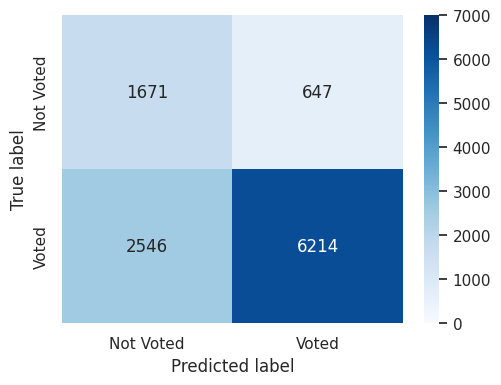

0:00:03.089962


In [13]:
init_time = time()

# best parameters
params = {'learning_rate': 0.1, 
         'max_depth': 10,
         'max_features': 'sqrt',
         'min_samples_leaf': 0.01, 
         'min_samples_split': 0.2, 
         'n_estimators': 100,
}

# Define and configure the GB pipeline
gb = imbPipeline([
        ('preprocessing', preprocessing_oh_target),
        ('undersampler', RandomUnderSampler(random_state=rng)),
        ('classifier', GradientBoostingClassifier(**params, random_state=rng))
    ])

# Fit and predict the model
gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)

# Compute metrics
results.loc['GB'] = compute_metrics(y_val, y_pred)
results

# Plot confusion matrix
plt = plot_confusion_matrix(y_val, y_pred)
plt.show()

print(timedelta(seconds=(time() - init_time)))

### CatBoost

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.089966
0:	learn: 0.6786690	total: 133ms	remaining: 1m 12s
1:	learn: 0.6586176	total: 868ms	remaining: 3m 57s
2:	learn: 0.6457912	total: 1.04s	remaining: 3m 10s
3:	learn: 0.6331633	total: 1.19s	remaining: 2m 42s
4:	learn: 0.6208888	total: 1.74s	remaining: 3m 9s
5:	learn: 0.6110197	total: 2.27s	remaining: 3m 25s
6:	learn: 0.6110197	total: 2.3s	remaining: 2m 58s
7:	learn: 0.6110196	total: 2.33s	remaining: 2m 37s
8:	learn: 0.6045797	total: 2.53s	remaining: 2m 32s
9:	learn: 0.6014278	total: 2.6s	remaining: 2m 20s
10:	learn: 0.5957031	total: 2.78s	remaining: 2m 16s
11:	learn: 0.5902666	total: 2.98s	remaining: 2m 13s
12:	learn: 0.5896985	total: 3s	remaining: 2m 4s
13:	learn: 0.5851644	total: 3.52s	remaining: 2m 14s
14:	learn: 0.5818355	total: 3.69s	remaining: 2m 11s
15:	learn: 0.5818355	total: 3.7s	remaining: 2m 3s
16:	learn: 0.5795386	total: 3.77s	remaining: 1m 58s
17:	learn: 0.5769619	total: 3.84s	remaining: 1m 53s
18:	learn: 0.5741536	total: 4.16s	remaining: 1m 56s
1

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['NFAMS', 'FAMSIZE', 'NCHILD',
                                                   'NCHLT5', 'NSIBS',
                                                   'YRIMMIG']),
                                                 ('imputer',
                                                  IterativeImputer(random_state=42),
                                                  ['UHRSWORKT'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7f32a21f6410>)])

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
LDA,0.509,0.792,0.650,0.723,0.392,0.872,0.713
QDA,0.494,0.805,0.649,0.657,0.396,0.864,0.696
GNB,0.490,0.807,0.648,0.645,0.396,0.862,0.692
KNN,0.490,0.791,0.640,0.681,0.382,0.864,0.695
LR,0.359,0.767,0.563,0.458,0.295,0.820,0.584
DT,0.488,0.765,0.627,0.733,0.366,0.866,0.698
RF,0.525,0.845,0.685,0.617,0.456,0.869,0.711
ET,0.516,0.828,0.672,0.645,0.429,0.869,0.709
AB,0.517,0.799,0.658,0.726,0.401,0.874,0.720
GB,0.511,0.796,0.653,0.721,0.396,0.872,0.715


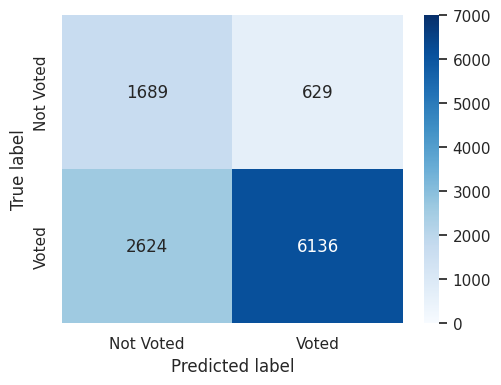

0:01:41.404791


In [14]:
from catboost import CatBoostClassifier

init_time = time()

# best parameters
params = {'iterations': 550,
          'objective': 'Logloss',
          'colsample_bylevel': 0.0466,
          'depth': 12,
          'iterations': 550,
          'boosting_type': 'Ordered',
          'bootstrap_type': 'MVS',
          'auto_class_weights': 'Balanced',
          'subsample': 0.661,
}            

cat = imbPipeline([
        ('preprocessing', preprocessing_num),
        ("classifier", CatBoostClassifier(random_state=rng, **params)),
])

cat_features = [i for i in range(len(num_cols_basic+num_cols_imputate),33)]
cat.fit(X_train, y_train, classifier__cat_features=cat_features,classifier__plot=True)
y_pred = cat.predict(X_val)

# Compute metrics
results.loc['CAT'] = compute_metrics(y_val, y_pred)
results

# Plot confusion matrix
plt = plot_confusion_matrix(y_val, y_pred)
plt.show()

print(timedelta(seconds=(time() - init_time)))

### Linear SVM

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['NFAMS', 'FAMSIZE', 'NCHILD',
                                                   'NCHLT5', 'NSIBS',
                                                   'YRIMMIG']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=25,
                                                                sparse_output=False),
                                                  ['GQTYPE', 'METRO', 'INTTYPE',
                                                   'SEX', 'VETSTAT', 'CITIZEN',
                                                   'DIFFANY', 'COVIDUNAW',
                                                   'NATIVITY', 'COVIDPAID',
                                                   'STATEFIP', 'RELATE', 'RACE',
                                                   'MARST', 'BPL', 'MBPL',
                                                   'FBPL', 'HISPAN', 'EMPSTAT',
                                                   'CLASSWKR',
                                                   'EMPSTAT_HEAD']),
                                                 ('imputer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   IterativeImputer(random_state=42))]),
                                                  ['UHRSWORKT'])])),
                ('classifier',
                 LinearSVC(C=0.05, class_weight='balanced', dual=False,
                           penalty='l1', random_state=42))])

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
LDA,0.509,0.792,0.650,0.723,0.392,0.872,0.713
QDA,0.494,0.805,0.649,0.657,0.396,0.864,0.696
GNB,0.490,0.807,0.648,0.645,0.396,0.862,0.692
KNN,0.490,0.791,0.640,0.681,0.382,0.864,0.695
LR,0.359,0.767,0.563,0.458,0.295,0.820,0.584
DT,0.488,0.765,0.627,0.733,0.366,0.866,0.698
RF,0.525,0.845,0.685,0.617,0.456,0.869,0.711
ET,0.516,0.828,0.672,0.645,0.429,0.869,0.709
AB,0.517,0.799,0.658,0.726,0.401,0.874,0.720
GB,0.511,0.796,0.653,0.721,0.396,0.872,0.715


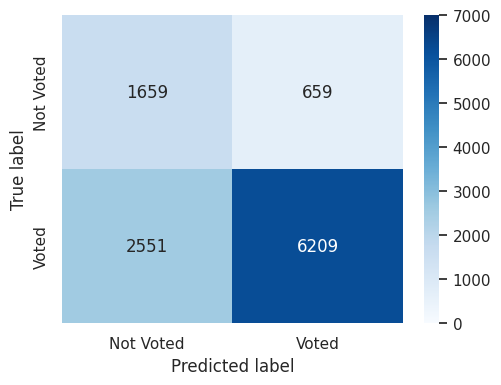

0:00:07.074472


In [15]:
init_time = time()

# Best parameters found
params = {'C': 0.05,
            'class_weight': 'balanced',
            'max_iter': 1000,
            'penalty': 'l1',
            'dual': False}

# Define and configure the Linear SVM pipeline
lsvm = imbPipeline([
        ('preprocessing', preprocessing_oh),
        ('classifier', LinearSVC(**params, random_state=rng))
    ])

# Fit and predict the model
lsvm.fit(X_train, y_train)
y_pred = lsvm.predict(X_val)

# Compute metrics
results.loc['LSVM'] = compute_metrics(y_val, y_pred)
results

# Plot confusion matrix
plt = plot_confusion_matrix(y_val, y_pred)
plt.show()

print(timedelta(seconds=(time() - init_time)))

In [16]:
# print the output ascending by F1 C0 and F1 C1
results.sort_values(by=['F1 C0'], ascending=False)

,F1 C0,F1 C1,F1 Macro,Recall C0,Precision C0,AP Macro,ROC AUC Macro
RF,0.525,0.845,0.685,0.617,0.456,0.869,0.711
AB,0.517,0.799,0.658,0.726,0.401,0.874,0.720
ET,0.516,0.828,0.672,0.645,0.429,0.869,0.709
GB,0.511,0.796,0.653,0.721,0.396,0.872,0.715
CAT,0.509,0.790,0.650,0.729,0.392,0.872,0.715
LDA,0.509,0.792,0.650,0.723,0.392,0.872,0.713
LSVM,0.508,0.795,0.651,0.716,0.394,0.871,0.712
QDA,0.494,0.805,0.649,0.657,0.396,0.864,0.696
GNB,0.490,0.807,0.648,0.645,0.396,0.862,0.692
KNN,0.490,0.791,0.640,0.681,0.382,0.864,0.695
